In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import date2num , DateFormatter
import datetime as dt

from statsmodels.tsa.api import VARMAX
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('full_corporate.csv', index_col=0)
data = data.set_index('datetime')
data.index = pd.DatetimeIndex(data.index)
data = data[data.index.dayofweek < 5]
data.shape

(57773, 15)

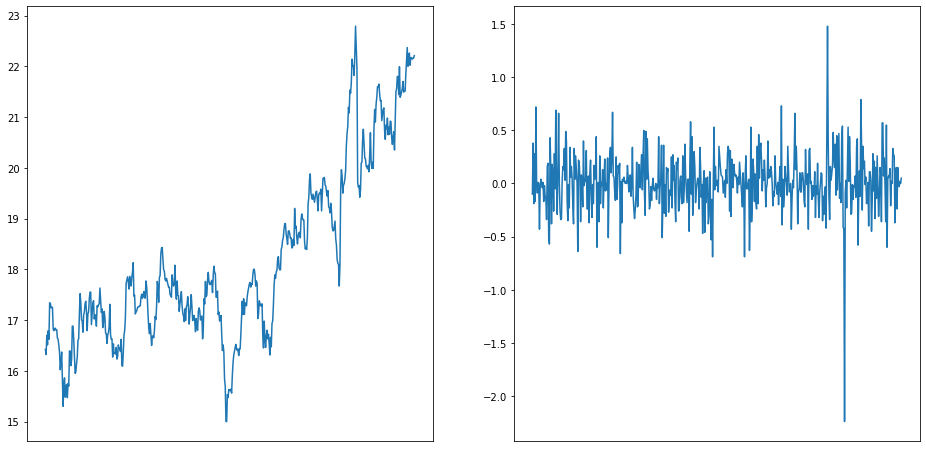

In [3]:
daily_close = data.groupby('day')['close/last'].mean()

fig, (ax1, ax2)= plt.subplots(1, 2, figsize=(16, 8))
ax1.plot(daily_close.index, daily_close)
ax1.set_xticks([])
ax2.plot(daily_close.index, daily_close.diff().round(2))
ax2.set_xticks([]);

In [4]:
def autocorrelation_plots(time_data, lags=20):
    import matplotlib.pyplot as plt
    import statsmodels.api as sm
    
    fig, ax = plt.subplots(2, 1, figsize=(10, 8))
    fig = sm.graphics.tsa.plot_acf(time_data, lags=lags, ax=ax[0])
    fig = sm.graphics.tsa.plot_pacf(time_data, lags=lags, ax=ax[1])
    plt.show()

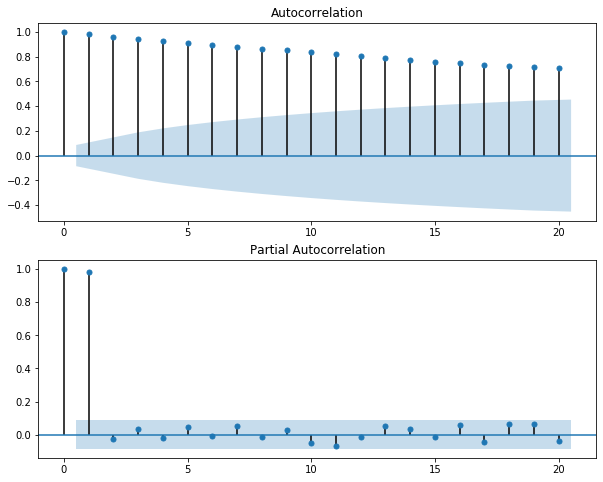

In [5]:
autocorrelation_plots(daily_close)

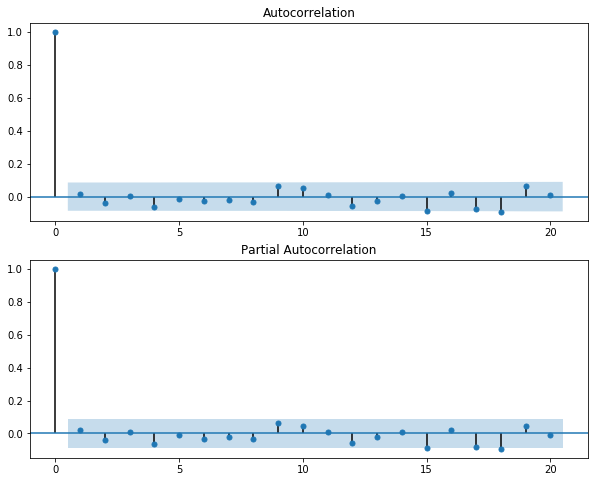

In [6]:
autocorrelation_plots(daily_close.diff().round(2).dropna())

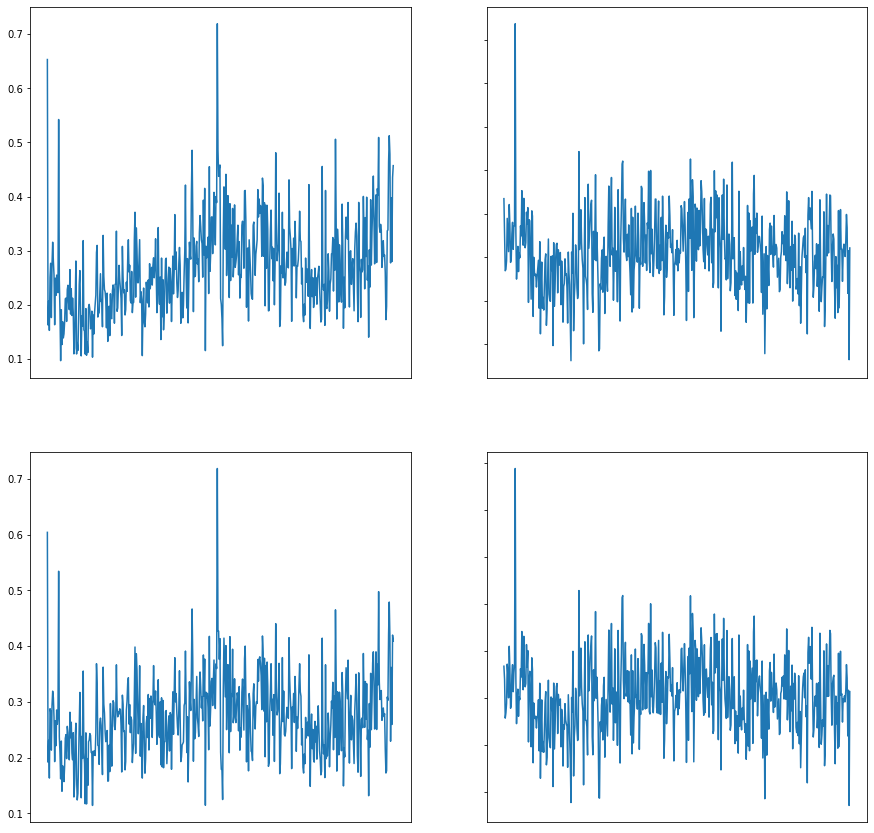

In [7]:
daily = data.groupby('day')[['vader_sentiment', 'blob_sentiment',
                        'clean_vader', 'clean_blob']].mean()

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 15))
ax1.plot(daily.index, daily['vader_sentiment'])
ax1.set_xticks([])
ax2.plot(daily.index, daily['blob_sentiment'])
ax2.set_xticks([])
ax3.plot(daily.index, daily['clean_vader'])
ax3.set_xticks([])
ax4.plot(daily.index, daily['clean_blob'])
ax4.set_xticks([])

for ax in fig.get_axes():
    ax.label_outer()

vader_sentiment


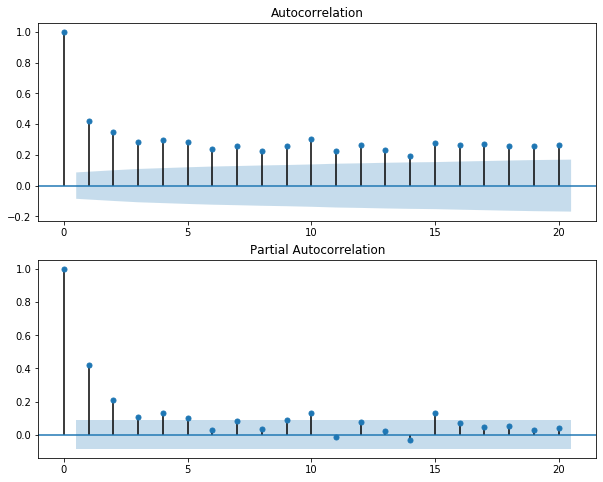


clean_vader


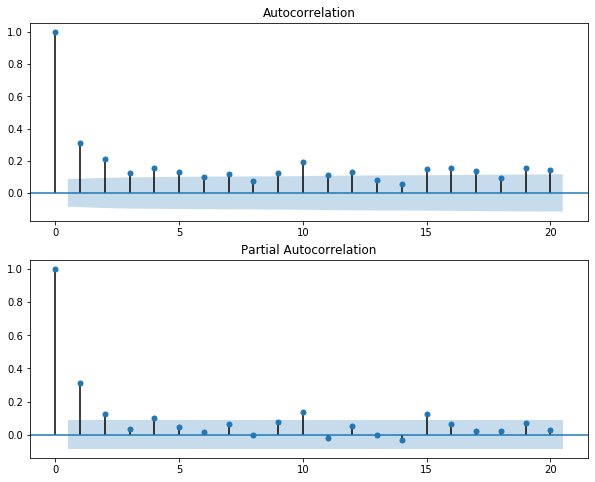


blob_sentiment


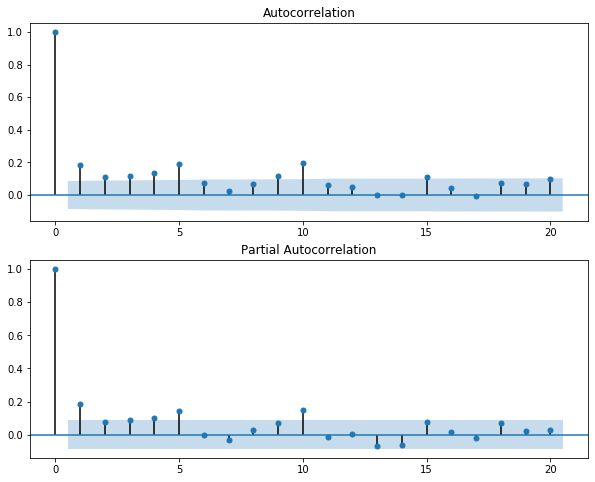


clean_blob


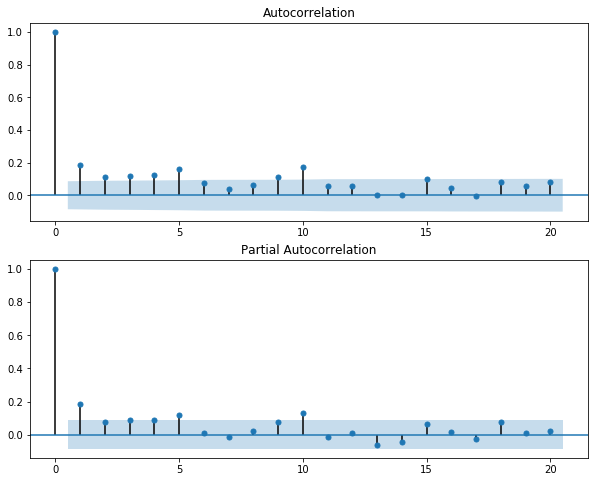

In [8]:
for col in ['vader_sentiment', 'clean_vader', 'blob_sentiment', 'clean_blob']:
    print(col)
    autocorrelation_plots(daily[col])
    print()

vader_sentiment


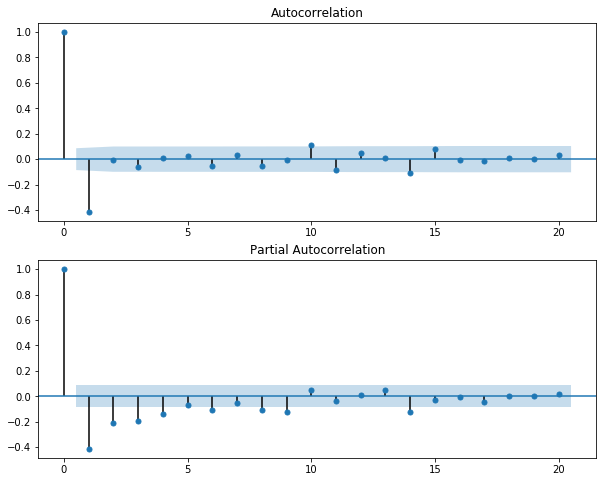


clean_vader


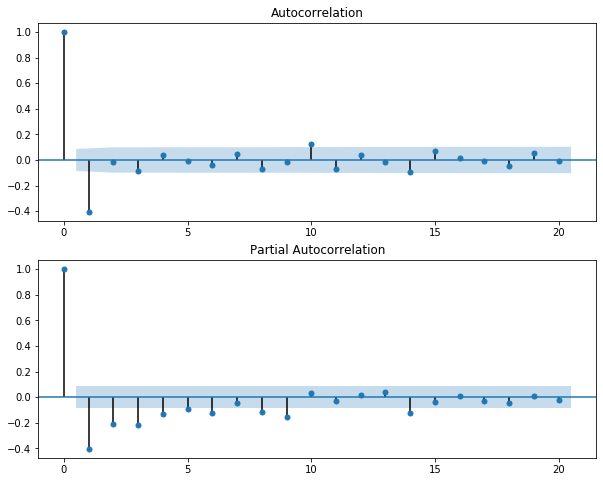


blob_sentiment


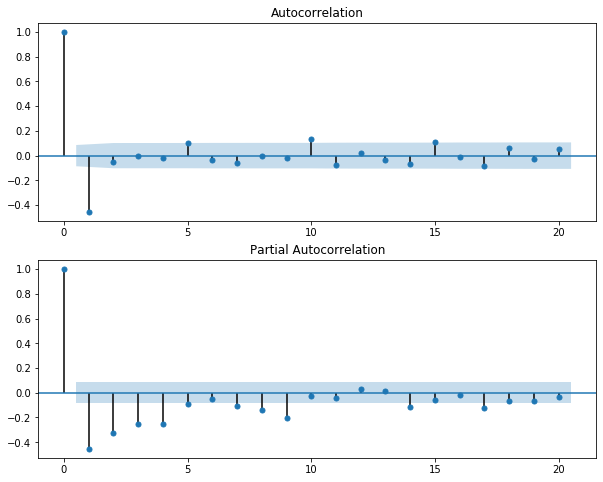


clean_blob


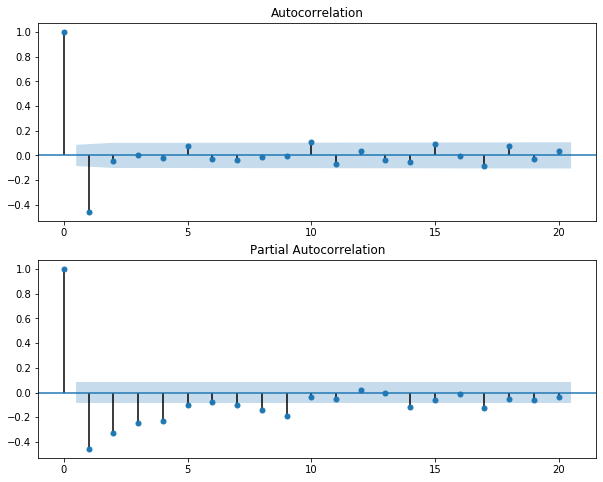

In [9]:
for col in ['vader_sentiment', 'clean_vader', 'blob_sentiment', 'clean_blob']:
    print(col)
    autocorrelation_plots(daily[col].diff().dropna())
    print()

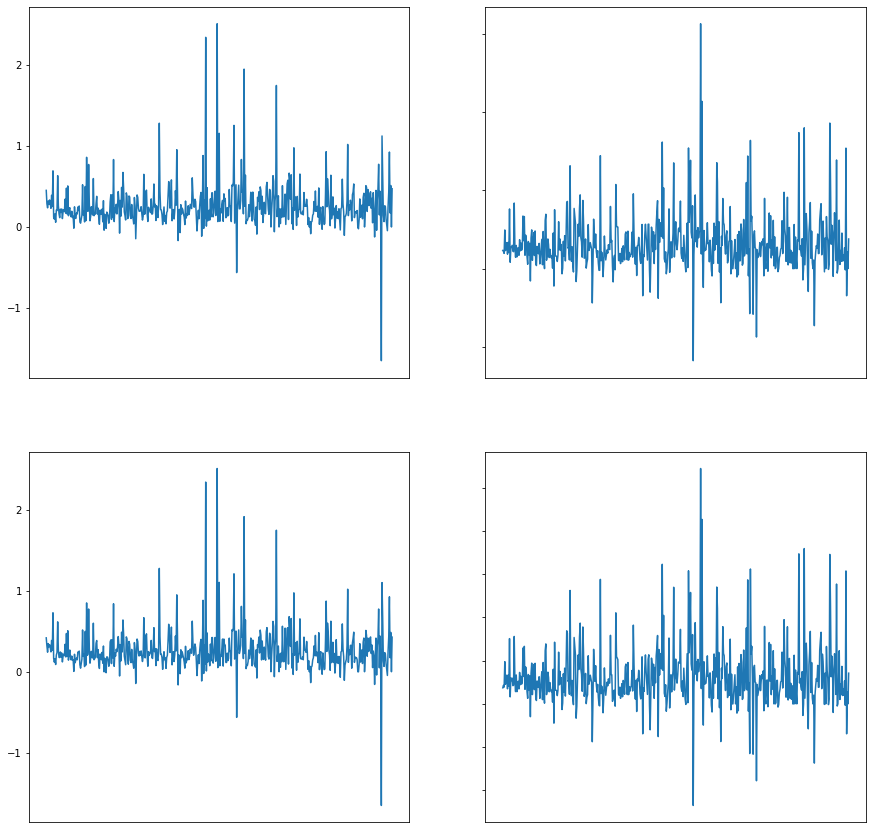

In [10]:
pop = data[data['retweets'] > 0]
pop['scale'] = [np.log(i+1) for i in pop['retweets']]
for col in ['vader_sentiment', 'blob_sentiment', 'clean_vader', 'clean_blob']:
    pop[col] = pop[col]*pop['scale']

daily_pop = pop.groupby('day')[
                        ['vader_sentiment', 'blob_sentiment',
                        'clean_vader', 'clean_blob']].mean()

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 15))
ax1.plot(daily_pop.index, daily_pop['vader_sentiment'])
ax1.set_xticks([])
ax2.plot(daily_pop.index, daily_pop['blob_sentiment'])
ax2.set_xticks([])
ax3.plot(daily_pop.index, daily_pop['clean_vader'])
ax3.set_xticks([])
ax4.plot(daily_pop.index, daily_pop['clean_blob'])
ax4.set_xticks([])

for ax in fig.get_axes():
    ax.label_outer()

vader_sentiment


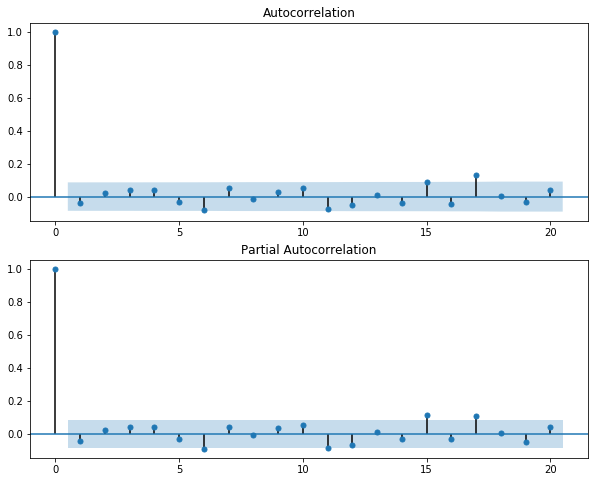


clean_vader


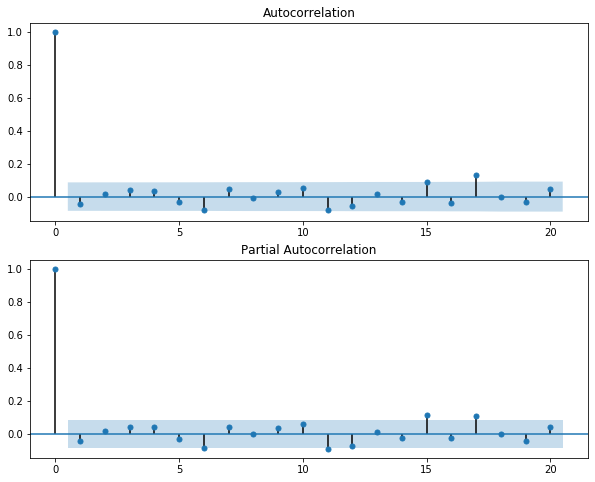


blob_sentiment


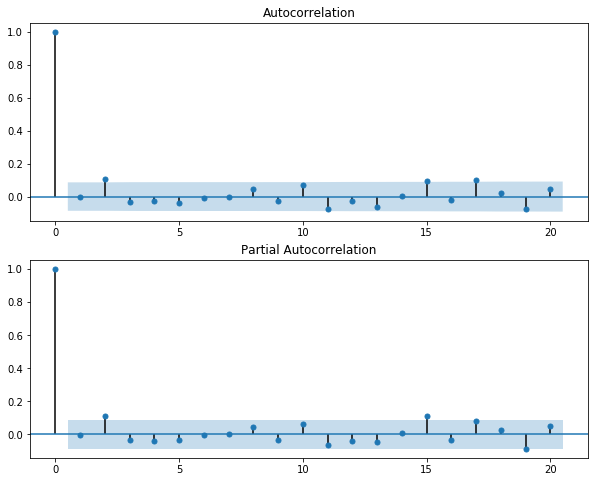


clean_blob


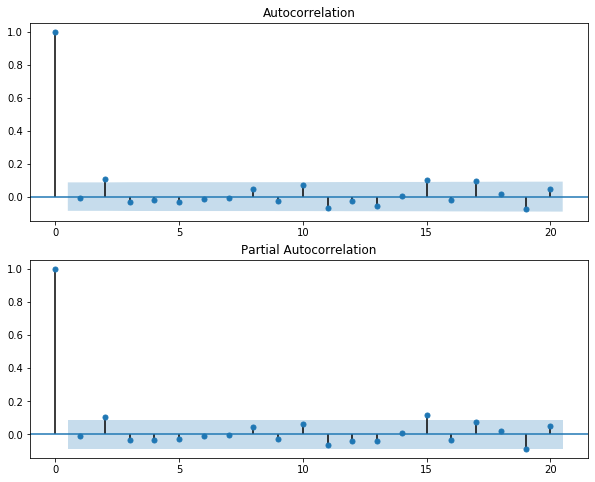

In [11]:
for col in ['vader_sentiment', 'clean_vader', 'blob_sentiment', 'clean_blob']:
    print(col)
    autocorrelation_plots(daily_pop[col])
    print()

vader_sentiment


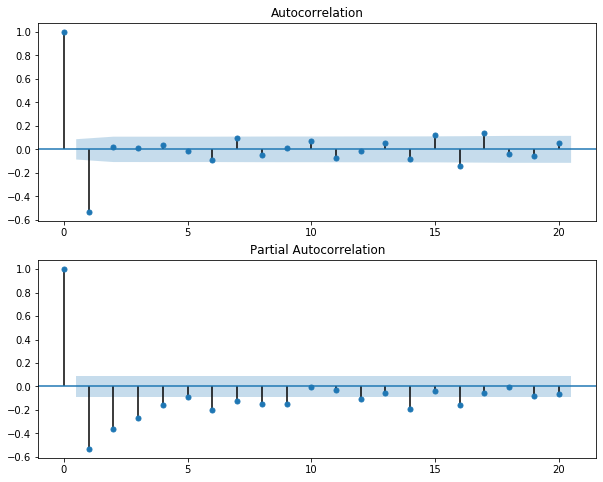


clean_vader


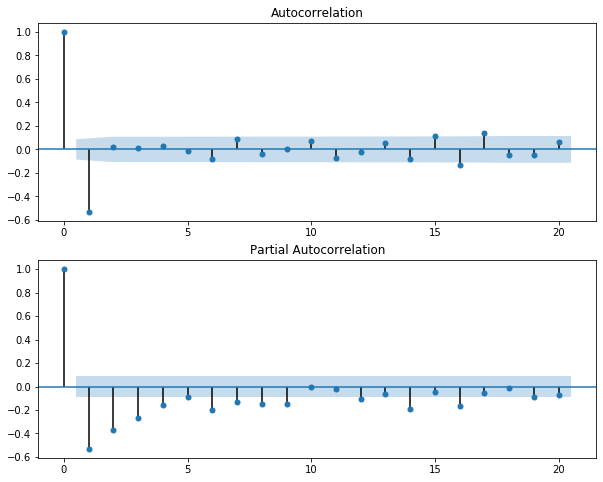


blob_sentiment


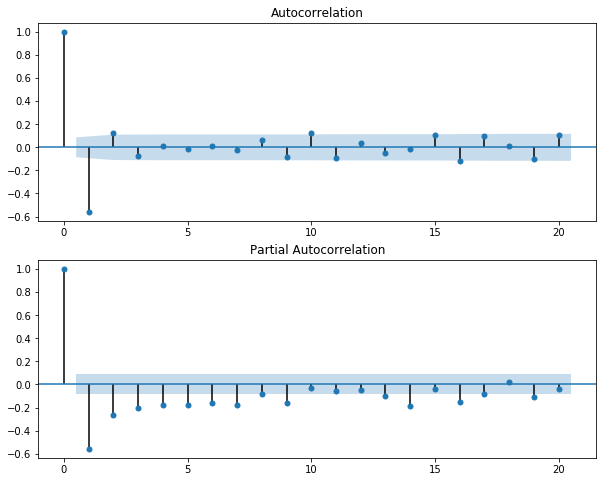


clean_blob


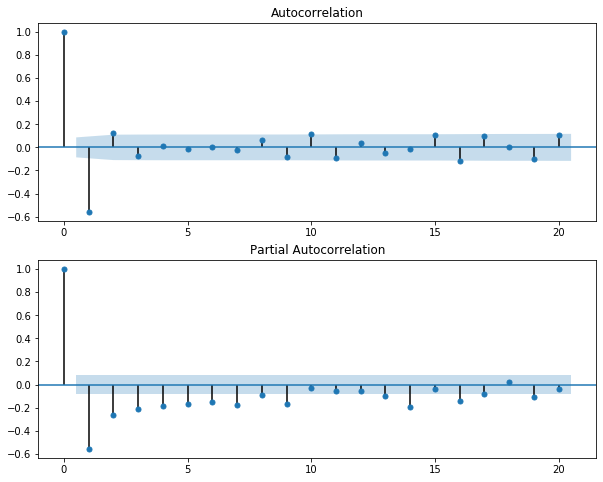

In [12]:
for col in ['vader_sentiment', 'clean_vader', 'blob_sentiment', 'clean_blob']:
    print(col)
    autocorrelation_plots(daily_pop[col].diff().dropna())
    print()

In [13]:
daily_close.shape[0]

522

In [14]:
y = daily_close.diff().iloc[:500]

aic = []
i=1
df_type = ['all', 'favorited']
for col in ['vader_sentiment', 'clean_vader', 'blob_sentiment', 'clean_blob']:
    for idx, df in enumerate([daily, daily_pop]):
        for lags in range(1, 8):
            x = df[col].diff().iloc[:500]
            train = pd.concat([y, x], axis=1)
            model = VARMAX(train, order=(lags, 0), trend='n')
            results = model.fit(maxiter=1000, disp=False)
            aic.append((f'{df_type[idx]} tweets, {col}, {lags} lags', results.aic))
            if i%7 == 0:
                print(f'{i} models run')
                print('...')
            i += 1
            
min(aic, key=lambda x: x[1])

7 models run
...
14 models run
...
21 models run
...
28 models run
...
35 models run
...
42 models run
...
49 models run
...
56 models run
...


('all tweets, clean_blob, 4 lags', -1612.2968923743892)

In [15]:
y = daily_close.diff()
x = daily['clean_blob'].diff()

model_data = pd.concat([y, x], axis=1).dropna()
train = model_data.iloc[:500]
test = model_data.iloc[500:]

model = VARMAX(train, order=(4, 0), trend='c')
results = model.fit(maxiter=1000, disp=False)
results.summary()

Dep. Variable:,"['close/last', 'clean_blob']",No. Observations:,500
Model:,VAR(4),Log Likelihood,826.282
,+ intercept,AIC,-1610.564
Date:,"Fri, 24 Apr 2020",BIC,-1522.057
Time:,17:45:26,HQIC,-1575.834
Sample:,01-02-2018,,
,- 12-02-2019,,
Covariance Type:,opg,,
Ljung-Box (Q):,"44.13, 67.62",Jarque-Bera (JB):,"2117.88, 48.53"
Prob(Q):,"0.30, 0.00",Prob(JB):,"0.00, 0.00"
Heteroskedasticity (H):,"1.60, 0.75",Skew:,"-0.75, 0.32"


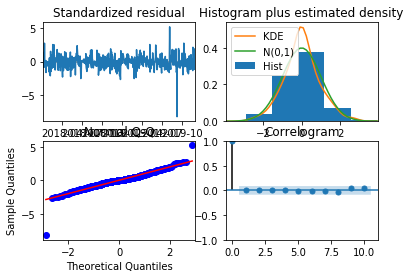

In [16]:
results.plot_diagnostics()
plt.show()

In [17]:
forecast = results.get_forecast(test.index[-1]).summary_frame()
forecast

close/last,mean,mean_se,mean_ci_lower,mean_ci_upper
2019-12-03,0.072256,0.271889,-0.460637,0.605150
2019-12-04,-0.033918,0.272064,-0.567153,0.499318
2019-12-05,0.026258,0.273405,-0.509606,0.562122
2019-12-06,-0.024367,0.273444,-0.560308,0.511573
2019-12-09,0.014235,0.273870,-0.522540,0.551009
2019-12-10,0.020643,0.273916,-0.516222,0.557508
2019-12-11,0.005714,0.273918,-0.531155,0.542583
2019-12-12,0.010500,0.273953,-0.526438,0.547439
2019-12-13,0.011113,0.273956,-0.525831,0.548058
2019-12-16,0.012498,0.273957,-0.524449,0.549445


In [18]:
last = daily_close.loc[train.index[-1]]
pred = []
upper = []
lower = []
for idx, i in enumerate(forecast['mean']):
    last += i
    pred.append(last)
    upper.append(last + forecast['mean_ci_upper'][idx])
    lower.append(last - abs(forecast['mean_ci_lower'][idx]))
forecast['pred'] = pred
forecast['upper'] = upper
forecast['lower'] = lower

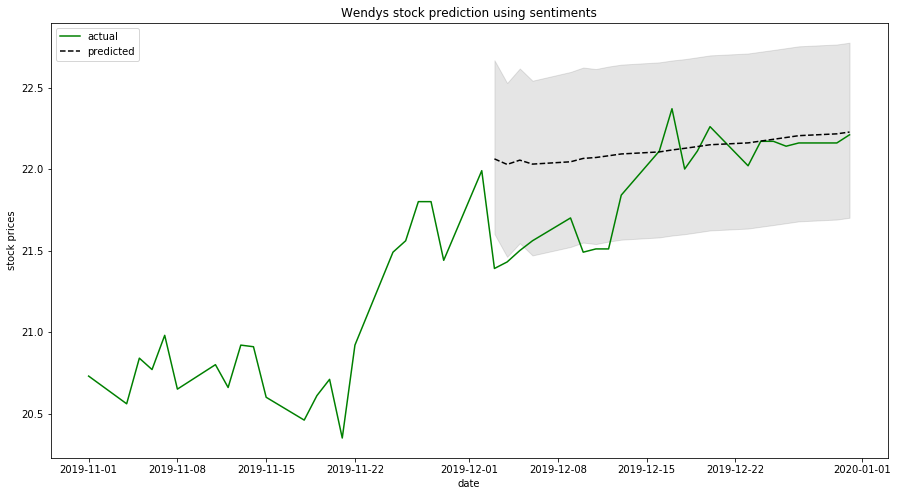

In [19]:
plt_data = pd.concat([daily_close.loc['2019-11-01':], forecast], axis=1)
x = pd.to_datetime(plt_data.index)

plt.figure(figsize=(15, 8))

plt.title('Wendys stock prediction using sentiments')
plt.ylabel('stock prices')
plt.xlabel('date')

plt.plot(x, plt_data['close/last'], 'g', label='actual')
plt.plot(x, plt_data['pred'], 'k--', label='predicted')
plt.fill_between(x, plt_data['lower'], plt_data['upper'], color='k', alpha=0.1)
plt.legend(loc=2);